# Аналитика в авиакомпании

> По материалам проекта курса от Яндекс.Практикума по анализу данных.

## Описание проекта
Для анализа представлены датасеты с информацией о рейсах, моделях самолетов, городах вылета. Необходимо импортировать файлы, изучить данные в них, проверить типы данных на корректность, выбрать топ-10 городов по количеству рейсов, построить графики: модели самолетов и количество рейсов, топ-10 городов и количество рейсов, сделать выводы по каждому из графиков, пояснить результат.

## Краткое описание данных

В качестве рабочих данных используются выборки из демонстрационной базы данных бронирования билетов, доступной по ссылке https://edu.postgrespro.ru/demo-small.zip

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

import psycopg2

In [2]:
conn = psycopg2.connect(dbname='demo', user='popov', password='******', host='localhost')

In [10]:
query = """SELECT air.model, COUNT(*)
  FROM bookings.flights AS fl
  JOIN bookings.aircrafts AS air
    ON fl.aircraft_code = air.aircraft_code
  GROUP BY air.model;
"""
flights = pd.read_sql(query, conn)

In [11]:
flights

,model,count
0,Bombardier CRJ-200,9048
1,Boeing 767-300,1221
2,Cessna 208 Caravan,9273
3,Boeing 737-300,1274
4,Sukhoi SuperJet-100,8504
5,Airbus A321-200,1952
6,Airbus A319-100,1239
7,Boeing 777-300,610


In [15]:
query = """SELECT fl.arrival_airport, ap.city, count(*)
  FROM bookings.flights fl
  JOIN bookings.airports ap
    ON ap.airport_code = fl.arrival_airport
  GROUP BY 1, 2 
  ORDER by 1;
"""

cities = pd.read_sql(query, conn)

In [38]:
flights_cities = cities.pivot_table(index='city', values='count', aggfunc='mean').reset_index()
flights_cities

,city,count
0,Абакан,235.0
1,Анадырь,34.0
2,Анапа,131.0
3,Архангельск,322.0
4,Астрахань,148.0
...,...,...
96,Чита,96.0
97,Элиста,296.0
98,Южно-Сахалинск,262.0
99,Якутск,167.0


## Исследовательский анализ данных

### Анализ взаимосвязи моделей самолетов и количества рейсов

In [40]:
#добавление столбца с % полетов с разными моделями
flights['percentage_of_flights'] = flights['count'] * 100 / flights['count'].sum()
flights

,model,count,percentage_of_flights
0,Bombardier CRJ-200,9048,27.318016
1,Boeing 767-300,1221,3.686483
2,Cessna 208 Caravan,9273,27.997343
3,Boeing 737-300,1274,3.846502
4,Sukhoi SuperJet-100,8504,25.675553
5,Airbus A321-200,1952,5.893542
6,Airbus A319-100,1239,3.740829
7,Boeing 777-300,610,1.841732


Сгруппируем датафрейм по маркам моделей авиалайнеров.

In [62]:
grouped_aircrafts = flights.groupby(flights.model.str.split(' ', 1, expand=True)[0]).sum() \
                                                 .sort_values(by='count', ascending=False) \
                                                 .reset_index() \
                                                 .rename({0: 'aircraft_group'}, axis='columns')
grouped_aircrafts

,aircraft_group,count,percentage_of_flights
0,Cessna,9273,27.997343
1,Bombardier,9048,27.318016
2,Sukhoi,8504,25.675553
3,Airbus,3191,9.634371
4,Boeing,3105,9.374717


Для визуальной оценки взаимосвязи количества рейсов и типа моделей на основании данных датасета `grouped_aircrafts` построим график распределения полетов.

In [63]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

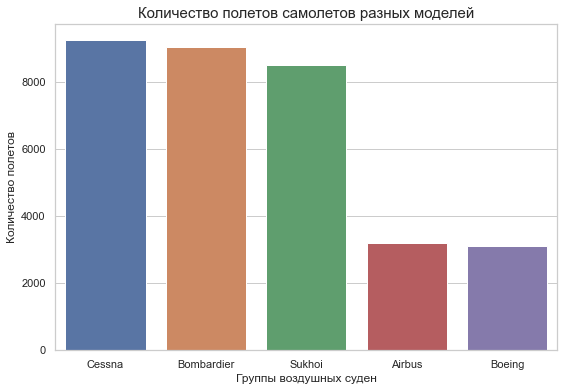

In [141]:
# построение графика количества полетов самолетов разных моделей
fig = plt.figure(figsize=(9, 6))
# добавление одного графика на иллюстрацию
ax = fig.add_subplot()
# создание графика
sns.barplot(x='aircraft_group', y='count', data=grouped_aircrafts, ax=ax)
# создание названий
ax.set_xlabel('Группы воздушных суден')
ax.set_ylabel('Количество полетов')
ax.set_title('Количество полетов самолетов разных моделей', fontsize=15);

Выделим классы воздушных судов в зависимости от их вместимости. Разделим все самолеты на комммерческие и общего пользования.

Для этого посчитаем количество мест для каждой модели.

К деловой авиации отнесем все машины с вместимостью более 20 пасажиромест.

In [72]:
query = """SELECT air.model, count(*) AS seats
  FROM bookings.seats st
  JOIN bookings.aircrafts air
    ON st.aircraft_code = air.aircraft_code
  GROUP BY air.model;
"""

seats = pd.read_sql(query, conn)
seats

,model,seats
0,Bombardier CRJ-200,50
1,Boeing 767-300,222
2,Cessna 208 Caravan,12
3,Boeing 737-300,130
4,Sukhoi SuperJet-100,97
5,Airbus A321-200,170
6,Airbus A319-100,116
7,Boeing 777-300,402
8,Airbus A320-200,140


In [92]:
import numpy as np
seats['type'] = np.where(seats.seats < 20, 'коммерческая', 'общего назначения')

In [99]:
flights_types = flights.merge(seats, on='model')
flights_types

,model,count,percentage_of_flights,seats,type
0,Bombardier CRJ-200,9048,27.318016,50,общего назначения
1,Boeing 767-300,1221,3.686483,222,общего назначения
2,Cessna 208 Caravan,9273,27.997343,12,коммерческая
3,Boeing 737-300,1274,3.846502,130,общего назначения
4,Sukhoi SuperJet-100,8504,25.675553,97,общего назначения
5,Airbus A321-200,1952,5.893542,170,общего назначения
6,Airbus A319-100,1239,3.740829,116,общего назначения
7,Boeing 777-300,610,1.841732,402,общего назначения


In [140]:
plt.pie?

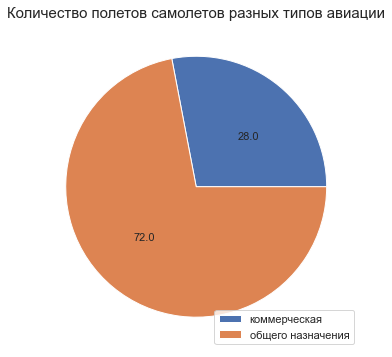

In [136]:
# cоздание круговой диаграммы типов авиации

flights_types_grouped = flights_types.groupby('type')
fig = plt.figure(figsize=(6, 6))
plt.pie(flights_types_grouped['count'].sum(),
             labels=flights_types_grouped['percentage_of_flights'].sum().round(2), labeldistance=.5)
plt.title('Количество полетов самолетов разных типов авиации', fontsize=15)
plt.legend(flights_types_grouped.groups.keys(), loc=4);

В таблице для удобства все сведения о моделях Airbus и Boeing были объединены, значения отсортированы по убыванию и построена диаграмма с количеством полетов разных моделей. После чего было принято решение проанализировать количество самолетов, относящихся к разным типам авиации — малой (до 9 мест, в основном частные и учебные полеты), деловой (до 20 мест, в основном корпоративные перелеты, перелеты официальных лиц и тд) и общего назначения (более 20 мест в самолете). Несмотря на то, что деловая и малая авиация занимают значительный сегмент полетов, однако все же полеты общего назначения представляют наибольшее количество полетов (72%).

## Анализ взаимосвязи города расположения аэропорта и количества рейсов

### Выбор топ-10 городов по количеству рейсов

In [145]:
top10 = flights_cities.sort_values(by='count', ascending=False)[:10]
top10

,city,count,percentage_of_flights
43,Москва,2638.666667,9.577158
70,Санкт-Петербург,1902.000000,6.903394
54,Новосибирск,1055.000000,3.829169
33,Красноярск,707.000000,2.566088
20,Екатеринбург,688.000000,2.497127
67,Ростов-на-Дону,620.000000,2.250318
63,Пермь,619.000000,2.246688
10,Брянск,610.000000,2.214022
74,Сочи,584.000000,2.119654
73,Советский,549.000000,1.992620


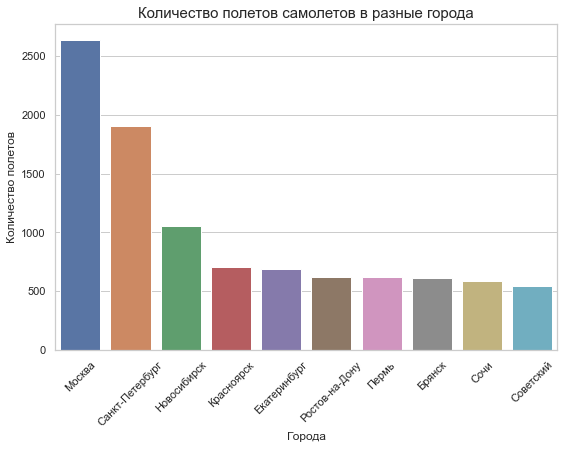

In [149]:
# построение графика количества полетов в топ-10 городов России
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
# создание графика
sns.barplot(x='city', y='count', data=top10, ax=ax)
# создание названий
plt.xticks(rotation=45)
ax.set_xlabel('Города')
ax.set_ylabel('Количество полетов')
ax.set_title('Количество полетов самолетов в разные города', fontsize=15);

Наиболее нагруженными на период исследования являются аэропорты Москвы, Санкт-Петербурга, Новосибирска, Красноярска, Екатеринбурга, Ростов-на-Дону, Сочи. Самыми гостепреимными стали (10% вылетов) аэропорты Москвы, также заметный процент авиаперелетов в Санкт-Петербург и Новосибирск, что связано как с высоким населением этих городов, так и с осуществлением пересадочных рейсов в них.